# Getting Started with Unstructured API and PostgreSQL



[Unstructured](https://unstructured.io) is an ETL+ platform for transforming unstructured content into structured formats ready for downstream use. It lets you:

* Connect to enterprise data sources — cloud storage (S3, Azure Blob), collaboration tools (Confluence, Dropbox), business apps (Salesforce, Jira, Zendesk), and databases (Databricks, Redis, PostgreSQL)
* Continuously ingest documents from those systems
* Standardize, enrich, chunk, and transform the content into clean structured output
* Store the results in a destination database — in this case, **PostgreSQL**

You can configure all of this through the Unstructured UI, the API, or directly from Python using their SDK.

This notebook walks through setting up a full data pipeline using the Unstructured API. We’ll source files from an S3 bucket, process them using a series of transformation steps, and insert the structured results into PostgreSQL — ready for querying, analytics, or integration into business applications.

For source configuration, we’ll use S3 in this example, though you can plug in any supported [data source](https://docs.unstructured.io/api-reference/workflow/sources/overview). The destination will be a PostgreSQL instance configured to receive structured document outputs via Unstructured’s [PostgreSQL connector](https://docs.unstructured.io/api-reference/workflow/destinations/postgresql).


This is what the complete data processing pipeline will look like:
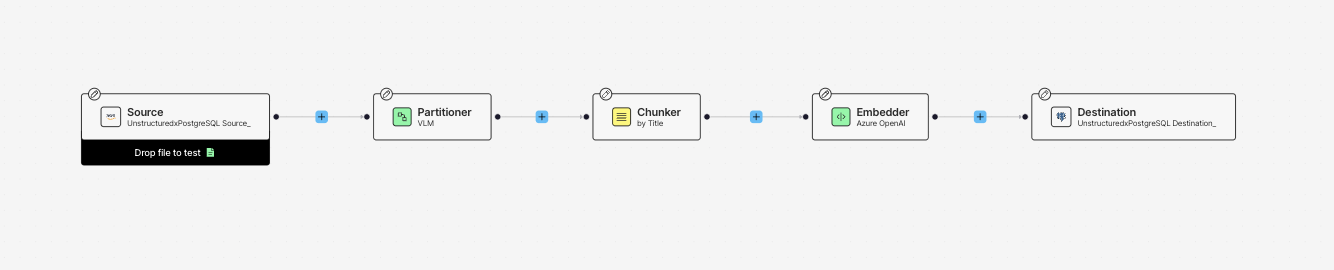


## Prerequisites

Before running this notebook, you’ll need a few things set up so that Unstructured can connect to your source (e.g. S3) and send processed data to PostgreSQL.


### Unstructured API Key

Create an API key from the Unstructured Platform

1. [Contact us](https://unstructured.io/enterprise) to get access or log in if you're already a user.
2. Once logged in, go to the **API Keys** section in the sidebar.
3. Click **New Key**, name it (e.g. `postgresql-workflow-key`), and copy it securely.

---

### AWS S3 (Source)

We’ll use S3 to source raw documents.

Make sure you have:

- **AWS Access Key** and **Secret**
- An **S3 bucket URI**, like: `s3://your-bucket/`
- A few files uploaded — PDF, DOCX, HTML, etc. See [supported file types](https://docs.unstructured.io/getting-started/ingest/supported-file-types) for reference.

Store these credentials securely in your notebook or environment variables.

---

### PostgreSQL (Destination)

You’ll need access to a PostgreSQL instance. For this tutorial, we’re using **Amazon RDS for PostgreSQL**, but other cloud-hosted options work as well.

When setting up your database, you’ll need to manually create the target table in advance. This table must match the structure of the document elements that Unstructured outputs.

Required connection details:

- **Host**
- **Port** (typically `5432`)
- **Database name**
- **Username**
- **Password**
- **Table name** — the destination table must already exist in your database and match the Unstructured output schema. For this tutorial, we'll use the table name: `elements`.
- **batch_size**: how many rows to insert per write operation


Ensure your PostgreSQL instance allows incoming connections from Unstructured’s IP addresses. If you're using Amazon RDS, check that your instance's **Public access** setting and **security group rules** permit access.  
→ [Unstructured IP list](https://assets.p6m.u10d.net/publicitems/ip-prefixes.json)

> 💡 You must create the destination table ahead of time. The schema should match the structure of Unstructured's document elements. Here's a sample schema you can adapt:
>
> ```sql
> CREATE TABLE elements (
>     id UUID PRIMARY KEY,
>     record_id VARCHAR,
>     element_id VARCHAR,
>     text TEXT,
>     embeddings DECIMAL [],
>     parent_id VARCHAR,
>     page_number INTEGER,
>     is_continuation BOOLEAN,
>     orig_elements TEXT,
>     partitioner_type VARCHAR
> );
> ```


For a full list of options and setup details, see the [PostgreSQL destination documentation](https://docs.unstructured.io/api-reference/workflow/destinations/postgresql).  
Prefer video? [Watch the setup walkthrough on YouTube](https://www.youtube.com/watch?v=QuIlEimejDs&t).


## Step 1: Install the Unstructured API Python SDK

All functionality available in the the UI of the [Unstructured](https://unstructured.io/) product is also available programmatically via Unstructured API. You can interact with Unstructured API either by sending direct requests via curl or postman, or using Unstructured API [Python SDK](https://docs.unstructured.io/api-reference/workflow/overview#unstructured-python-sdk). Here, we'll be using the latter.


> **Note:**
The Unstructured API has two endpoints:
* The Unstructured Partition Endpoint: intended for rapid prototyping of Unstructured's various partitioning strategies. It works only with processing of local files, one file at a time.
* The Unstructured Workflow Endpoint: enables a full range of partitioning, chunking, embedding, and enrichment options for your data. It is designed to batch-process data from any data source to any destination. This is what we're using in this notebook.


Run the following cell to install the Unstructured API Python SDK.

In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 3.9 MB/s eta 0:00:00


## Step 2: Set environment variables

Fetching the values from Colab Secrets!

In [ ]:
import os
from google.colab import userdata

# Unstructured
os.environ['UNSTRUCTURED_API_KEY'] = userdata.get('UNSTRUCTURED_API_KEY')

# AWS S3
os.environ['AWS_ACCESS'] = userdata.get('AWS_ACCESS')
os.environ['AWS_SECRET'] = userdata.get('AWS_SECRET')
os.environ['S3_REMOTE_URL'] = userdata.get('S3_REMOTE_URL')


# AWS PostgreSQL
os.environ['PostgreSQL_host'] = userdata.get('PostgreSQL_host')
os.environ['PostgreSQL_database'] = userdata.get('PostgreSQL_database')
os.environ['PostgreSQL_port'] = userdata.get('PostgreSQL_port')
os.environ['PostgreSQL_username'] = userdata.get('PostgreSQL_username')
os.environ['PostgreSQL_password'] = userdata.get('PostgreSQL_password')




In [ ]:
# instantiate Unstructured Client
from unstructured_client import UnstructuredClient

unstructured_client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

# helper function
def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

## Step 3: Create the source connector

Run the following cell to create an [AWS S3 source connector](https://docs.unstructured.io/api-reference/workflow/sources/s3).

When creating a source connector, you'll need to:
- Assign it a unique name
- Set the connector type to `s3`
- Provide your AWS credentials and S3 bucket location

Your config must include:
- `remote_url`: the full URI to your S3 bucket or folder (e.g. `s3://your-bucket/path/`)
- `key`: your AWS access key
- `secret`: your AWS secret key
- `recursive`: (optional) whether to include files in subfolders


In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import CreateSourceConnector

source_response = unstructured_client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name=f"UnstructuredxPostgreSQL Source_",
            type="s3",
            config={
              "key": os.environ.get('AWS_ACCESS'),
              "secret": os.environ.get('AWS_SECRET'),
              "remote_url": os.environ.get('S3_REMOTE_URL'),
              "recursive": True
            }
        )
    )
)

pretty_print_model(source_response.source_connector_information)

/usr/local/lib/python3.11/dist-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  function=lambda v, h: h(v),
/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  return self.__pydantic_serializer__.to_python(


{
    "config": {
        "anonymous": false,
        "recursive": true,
        "remote_url": "s3://ajay-uns-devrel-content/mm-agentic-rag/",
        "key": "**********",
        "secret": "**********"
    },
    "created_at": "2025-08-11T14:30:57.981194Z",
    "id": "b517c8b2-d309-4c5b-9eb1-3578d1f848c8",
    "name": "UnstructuredxPostgreSQL Source_",
    "type": "s3",
    "updated_at": "2025-08-11T14:30:58.256737Z"
}


/usr/local/lib/python3.11/dist-packages/unstructured_client/models/shared/sourceconnectorinformation.py:182: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  serialized = handler(self)


## Step 4: Create the destination connector

Run the following cell to create a [PostgreSQL destination connector](https://docs.unstructured.io/api-reference/workflow/destinations/postgresql).

When setting up a destination connector, you'll need to:
- Give it a unique name.
- Specify its type (`postgres` in this case).
- Provide configuration details including your PostgreSQL instance and table settings.

Your configuration must include:
- `host`: the hostname of your PostgreSQL instance
- `port`: the port number (usually `5432`)
- `database`: the name of the database
- `username`: your PostgreSQL username
- `password`: your PostgreSQL password
- `table_name`: the name of the table where data will be inserted
- `batch_size`: number of rows to insert per operation


In [ ]:

from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import CreateDestinationConnector

destination_response = unstructured_client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name="UnstructuredxPostgreSQL Destination_",
            type="postgres",
            config={
                    "host": os.environ['PostgreSQL_host'],
                    "database": os.environ['PostgreSQL_database'],
                    "port": os.environ['PostgreSQL_port'],
                    "username": os.environ['PostgreSQL_username'],
                    "password": os.environ['PostgreSQL_password'],
                    "table_name": "elements",
                    "batch_size": 100
                }
        )
    )
)

pretty_print_model(destination_response.destination_connector_information)

{
    "config": {
        "batch_size": 100,
        "database": "uns_devrel_demo",
        "host": "database-1.cmhg4iuswe98.us-east-1.rds.amazonaws.com",
        "password": "**********",
        "port": 5432,
        "table_name": "elements",
        "username": "postgres"
    },
    "created_at": "2025-08-18T13:32:24.631827Z",
    "id": "c4b79641-20f5-45b2-afd6-fe3b9a4efc9d",
    "name": "UnstructuredxPostgreSQL Destination_",
    "type": "postgres",
    "updated_at": "2025-08-18T13:32:24.750518Z"
}


/usr/local/lib/python3.11/dist-packages/unstructured_client/models/shared/destinationconnectorinformation.py:190: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='postgres', input_type=str])
  serialized = handler(self)


## Step 5: Create the data processing workflow

This step connects everything. We define a workflow that pulls files from S3, processes them through a sequence of transformations, and pushes the structured output to PostgreSQL.

The pipeline includes three core operations:

- **Partitioning**: Converts raw files like PDFs, DOCX, and HTML into structured elements — paragraphs, tables, titles, and more. We’re using the [`vlm` strategy](https://docs.unstructured.io/api-reference/partition/document-elements), which is well-suited for complex or layout-heavy documents.

- **Chunking**: Splits longer content into smaller pieces to make records easier to query and work with downstream. We use [`chunk_by_title`](https://docs.unstructured.io/api-reference/partition/chunking#%E2%80%9Dby-title%E2%80%9D-chunking-strategy), which breaks text at logical section boundaries based on headers and character count.

- **Embedding**: Adds a semantic vector to each chunk using Azure OpenAI’s `text-embedding-3-large`. Learn more about [embedding models and options](https://docs.unstructured.io/ui/embedding).

Once defined, these steps are passed into `create_workflow`, which registers the entire pipeline. From there, documents can be processed end-to-end — source to destination — with structured, enriched records landing in Postgres.


In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type="partition",
    settings={
        "provider": "anthropic",
        "model": "claude-sonnet-4-5-20250929",
        }
    )

chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 1000,
        "max_characters": 4096,
        "overlap": 150
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-large'
        }
    )


response = unstructured_client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": "PostgreSQL Destination Tutorial Workflow_",
            "source_id": source_response.source_connector_information.id,
            "destination_id": destination_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                chunk_node,
                embedder_node
            ]
        }
    }
)

pretty_print_model(response.workflow_information)
workflow_id = response.workflow_information.id

## Step 6: Run the workflow

Run the following cell to start running the workflow.

In [ ]:
res = unstructured_client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-08-11T15:13:16.416810Z",
    "id": "036eff90-49a3-46d0-ab97-be5541bfc32e",
    "status": "SCHEDULED",
    "workflow_id": "a84445dc-ddd1-4c68-acf6-482c2f211b40",
    "workflow_name": "PostgreSQL Destination Tutorial Workflow_",
    "job_type": "ephemeral"
}


## Step 7: Get the workflow run's job ID

Run the following cell to get the workflow run's job ID, which is needed to poll for job completion later. If successful, Unstructured prints the job's ID.

In [ ]:
response = unstructured_client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 036eff90-49a3-46d0-ab97-be5541bfc32e


## Step 8: Poll for job completion

Run the following cell to confirm the job has finished running. If successful, Unstructured prints `"status": "COMPLETED"` within the information about the job.

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = unstructured_client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-08-11T15:13:16.416810",
    "id": "036eff90-49a3-46d0-ab97-be5541bfc32e",
    "status": "COMPLETED",
    "workflow_id": "a84445dc-ddd1-4c68-acf6-482c2f211b40",
    "workflow_name": "PostgreSQL Destination Tutorial Workflow_",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


## Step 9: View the processed data

Once the job finishes, your documents will be processed and stored in PostgreSQL. Each row in the target table represents a structured element from the original files — including metadata, chunked text, and embeddings.

You can query the data directly using SQL. For example:

```sql
SELECT id, LEFT(text, 100) AS text_preview
FROM elements
LIMIT 5;
```



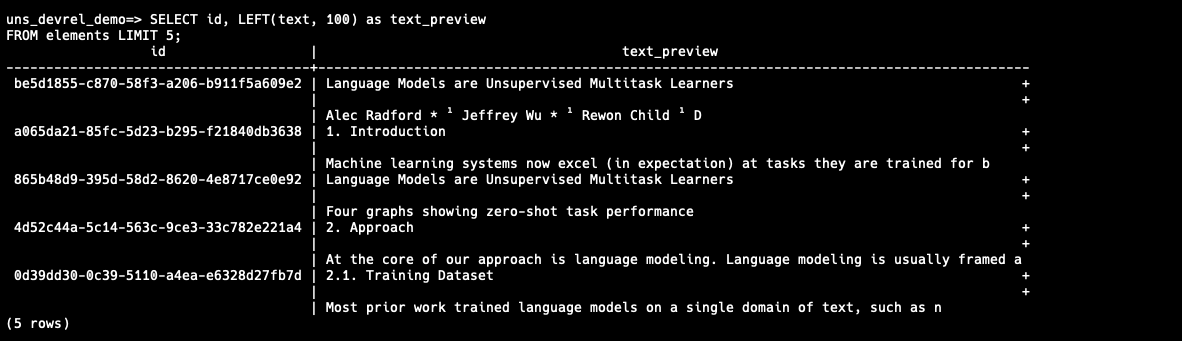